# More on resampling & randomization methods

In this lab we will go over bootstrapping and permutation resampling methods. 

## Goals of the lab:
* Learn to use the boot() function
* Learn to write _for loops_ to do permutation tests
* Construct a null distribution by permutation as a way of testing hypotheses 
* Quantify the sampling distribution of a statistic via bootstrapping (construct confidence intervals for your results)

This lab draws from the practice sets at the end of Chapter 5 in James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r." 

##  A reminder of the difference between bootstrapping and permutation testing

Both bootstrapping and permutation testing rely on randomization methods. However, their purposes are different, and often confused.

**Bootstrapping** 
* quantifies uncertainty by reusing the data {random resampling with *replacement*}
* answers the question: what is the range of values I can expect for a statistic, given the varaibility in my data? 


**Permutation testing** 
* breaks whatever structure may exist between variables of interest while maintaining the structure between others {permute, or shuffle, the relationship between *x* variables of interest and *y*, for example}
* allows targeted null hypothesis testing 
* quantifies the null distribution for a given hypothesis 
* answers the question: what kind of pattern would you expect to see if there were no statistical relationship between two (or more) variables?


These methods are useful if you need **non-parametric** estimates of uncertainty for a given statistic (bootstrapping) or if you need a non-parametric way of testing your hypotheses (permutation). In other words, if you don't want to risk making assumptions about the functional form of your data during uncertainty estimation or hypothesis testing, these randomization methods are for you.

However, keep in mind that there are cons (and assumptions) associated with non-parametric methods. For example, one major limitation of bootstrapping is that you must make the assumption that your data contains variability similar to the kind of variability you might see when you sample new datasets in the wild, given the same statistical model, to make inferential interpretations. See [here](http://pillowlab.princeton.edu/teaching/mathtools16/slides/lec21_Bootstrap.pdf) and [here](http://evolution.gs.washington.edu/gs560/2011/lecture8.pdf) for more information. 


---
# Bootstrapping

Moving on from cross-validation approaches, we'll now turn to how to bootstrap confidence intervals on your results. We'll stick with the Auto data set for this.

For the bootstrap we'll want to write our own functions for maximum flexibility.

First define a function that takes two inputs (a data set and an index of observations) and returns the parameter of interest. 

For this example, we'll return the regression coefficients for the model predicting _mpg_ from _horsepower_. 

In [7]:
library(ISLR)
library(boot)

In [8]:
# The function needs two inputs: Data, Index
boot.fn = function(data, index)
  # return: throw this as output
  # coef: extract coefficients from model object 
  return(coef(lm(mpg~horsepower, data=data, subset=index)))

Let's test this to make sure it works. We'll use an index array that takes all 392 observations (rows) in the data set.

In [9]:
boot.fn(Auto, 1:392)

(Intercept)  horsepower 
 39.9358610  -0.1578447

Notice this is the same output as when you just run the _lm()_ function with no subset selection (sanity check passed!).

In [10]:
coef(lm(mpg~horsepower, data=Auto))

(Intercept)  horsepower 
 39.9358610  -0.1578447

Now we can use the _boot()_ function, included in the _boot_ library, to randomly sample _with replacement_ to generate a confidence interval on the regression coefficient. We'll just test it out with 1000 iterations (set using the _R_ value as an input)

In [ ]:
#?boot 

In [16]:
boot_obj = boot(Auto ,boot.fn ,R=1000) #R=repetitions 
print(boot_obj) #t1 is the intercept and t2 is the horsepower coeff.


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
      original        bias    std. error
t1* 39.9358610  0.0371407529 0.856063499
t2* -0.1578447 -0.0003989892 0.007364241


In [17]:
# attributes(boot_obj) #get all attributes of the boot object 

Here the standard error estimate of the two regression coefficients (one for the intercept and one for _horsepower_) are calculated from the 1000 bootstrapped experiments on the data set. We can see the output from each of the 1000 iterations as well (below we'll plot just for $\hat{\beta}_{horsepower}$.

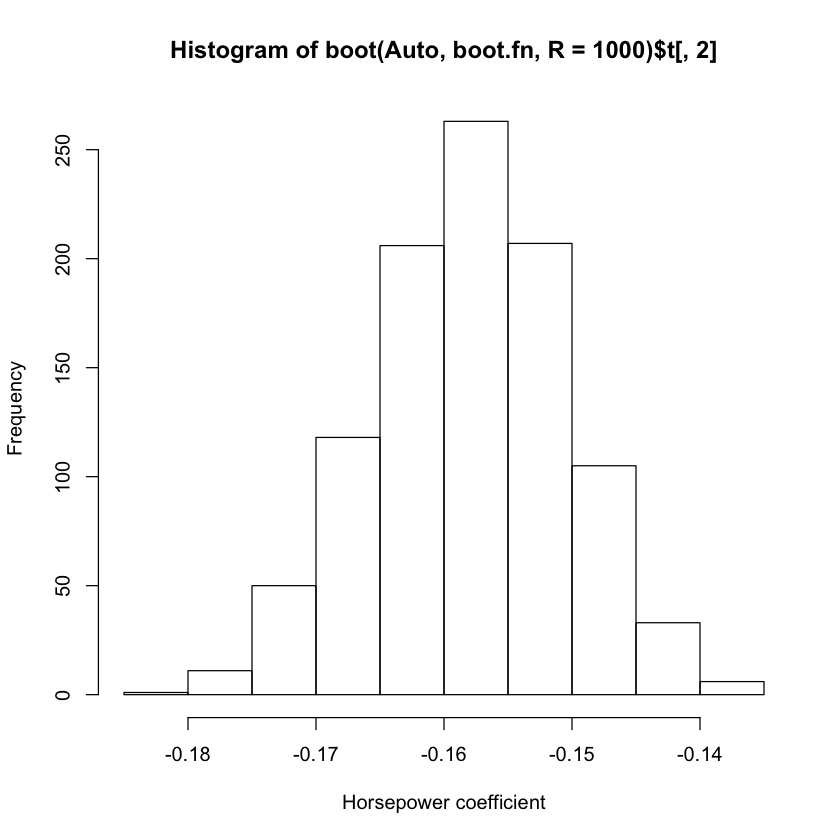

In [19]:
hist(boot(Auto ,boot.fn ,R=1000)$t[,2], xlab="Horsepower coefficient") #we get a distribution of all of the estimates

Now let's compare these results from the original model where we don't bootstrap.

In [21]:
# Bootstrap
boot(Auto ,boot.fn ,R=1000)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
      original        bias    std. error
t1* 39.9358610  0.0217088589  0.87400998
t2* -0.1578447 -0.0003301745  0.00756301

In [20]:
# Parametric model
summary(lm(mpg~horsepower ,data=Auto))$coef


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Auto, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
      original        bias    std. error
t1* 39.9358610  0.0362326353  0.87603173
t2* -0.1578447 -0.0003977898  0.00747557

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),39.9358610,0.717498656,55.65984,1.220362e-187
horsepower,-0.1578447,0.006445501,-24.48914,7.031989e-81


Notice that they produce qualitatively similar results in this case. When the data fit the assumptions of the parametric linear regression model, the bootstrapped estimates will converge to the parametric ones.

---
# Permutation tests

Remember, that the goal of permutation tests is to use resampling _without replacement_. Basically you define the specific null that you want to test and generate a random relationship with which to calculate $P(X|H_0)$. For this we can just use a simple _for_ loop. But first, we need to define what our null is. Here let's define our null as being that there is no relationship between _horsepower_ and _mpg_. In other words
$$H_0 : \hat{\beta}_{horsepower} = 0$$

**Note:** You are not restricted to these 'nil' hypotheses (effect of 0, $\beta$ of 0). The advantage of these kinds of methods is that you can be as flexible as you like in defining your null. 

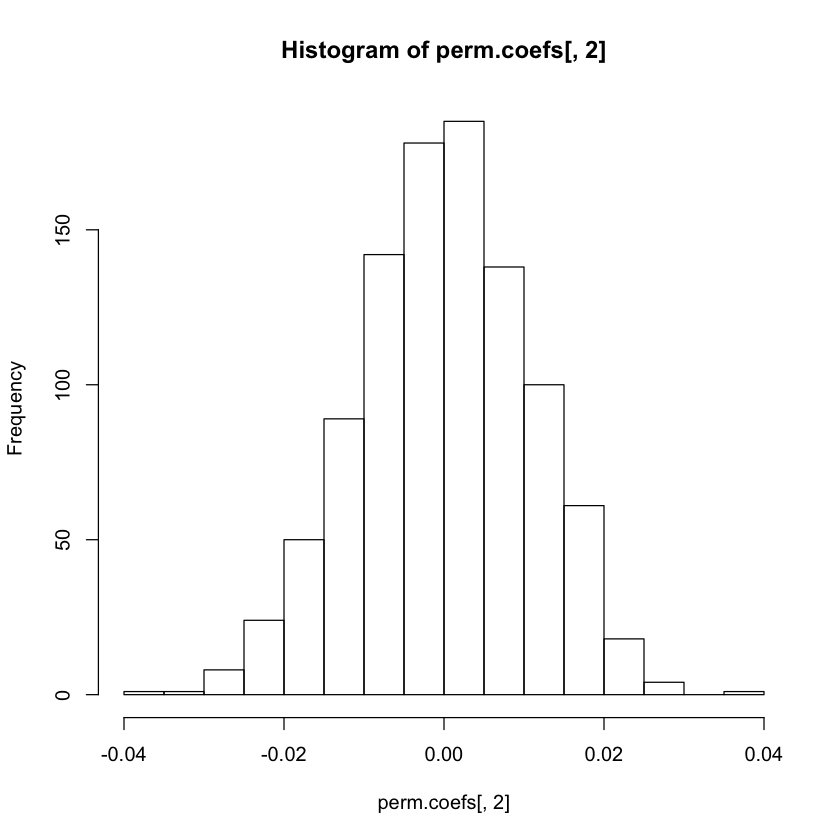

In [22]:
# First let's make a copy of the data set that we'll keep permuting
permAuto = Auto #don't want to mix permuted vsn and intact vsn!

# Set the number of iterations
R=1000

# Next smake an output object to store the results
perm.coefs=matrix(NA,nrow=R, ncol=2) #filling with nas at first

# Now just write a for loop where we scramble the observations
# in X using the sample() function
for (i in 1:R){
  permAuto$horsepower=Auto$horsepower[sample(392)]
  perm.coefs[i,]=coef(lm(mpg~horsepower, data=permAuto))
}

# Take a look at the null distributions
hist(perm.coefs[,2])


In [23]:
# Now re-estimate the real (unpermuted) effect 
perm.real = coef(lm(mpg~horsepower, data=Auto))
perm.real

(Intercept)  horsepower 
 39.9358610  -0.1578447

Notice that the real effect (-0.16) is _much_ large, and seems to fall outside the range of values in our empirically derived null distribution. But let's **empirically calculate** the probability of observing a stronger (i.e., more negative) effect. 

In [27]:
# Since the real effect of X (B1) is negative, we want to know
# the probabilty of observing a stronger negative effect
# just due to chance.

#sum the coefficients less than the real coefficient estimate 
#and divide by the number of repetitions to get an empirical probability 
perm.p = sum(perm.coefs[,2]<perm.real[2])/R 
perm.p

[1] 0

So we do not see any permuted models that produce results that overlap with the results from the  intact model, so we can reject the null hypothesis that the $\beta$ estimate for the miles per gallon and horsepower is zero. 

# Simulation time

Use the Boston housing data set for these exercises, from the MASS
library.

In [32]:
library(MASS)
head(Boston)

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


## The bootstrap

1) Based on this data set, provide an estimate for the population
mean of medv. 

2) Provide an estimate of the standard error of that mean. Interpret this
result.
(Compute the standard error of the sample mean by
dividing the sample standard deviation by the square root of the
number of observations.)

3) Now estimate the standard error of the population mean using the bootstrap. How
does this compare to your answer from (2)?

4) Based on your bootstrap estimate from (3), provide a 95% confidence
interval for the mean of medv. Compare it to the results
obtained using $$t.test(Boston$medv)$$

<br>
(Hint: You can approximate a 95% confidence interval using the formula $$\mu − 1.96SE(\mu), \mu) + 1.96SE(\mu))$$)

5) We now would like to estimate the standard error of the median for medv. Unfortunately,
there is no simple formula for computing the standard
error of the median. Instead, estimate the standard error of the
median using the bootstrap. Comment on your findings.

## Permutation testing 

1) Using your knowledge of permutation testing, test the null hypothesis that there is no interaction between crime and age, 
or $$H_0 : \hat{\beta}_{age}*\hat{\beta}_{crime} = 0$$

2) Compare this to the original estimate (unpermuted), and calculate the empirical probability of observing a stronger or weaker effect, depending on the sign of the original result. 

3) Bonus? Test any non-nil hypothesis using the spirit of the permutation method. 